# 使用``ResNet``从零实现迁移学习

In [1]:
import utils
import mxnet as mx
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import autograd
from mxnet import image
from mxnet import metric
from time import time 

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

## 下载并读取数据集

In [2]:
root_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/'
data_url = '../data/'

dataset_files = {
    'train': ('not_hotdog_train-e6ef27b4.rec', '0aad7e1f16f5fb109b719a414a867bbee6ef27b4'),
    'validation': ('not_hotdog_validation-c0201740.rec', '723ae5f8a433ed2e2bf729baec6b878ac0201740')
}

train_dataset, train_hash = dataset_files['train']
validation_dataset, validation_hash = dataset_files['validation']


import os

def get_data_batch(batch_size, data_shape):
    if not os.path.exists(data_url+train_dataset) or not os.path.exists(data_url+validation_dataset):
        gluon.utils.download(url=root_url+train_dataset, path=data_url+train_dataset, 
                         sha1_hash=train_hash)
        gluon.utils.download(url=root_url+validation_dataset, path=data_url+validation_dataset, 
                         sha1_hash=validation_hash)
    # 使用gluon的方法读取rec文件时必须要idx，因此这里我们用mx的方法来读取
    train_iter = mx.io.ImageRecordIter(path_imgrec=train_dataset,
                                   min_img_size=256,
                                   data_shape=data_shape,
                                   batch_size=batch_size,
                                   rand_crop=True,
                                   shuffle=True,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
    val_iter = mx.io.ImageRecordIter(path_imgrec=validation_dataset,
                                 min_img_size=256,
                                 data_shape=data_shape,
                                 batch_size=batch_size)
    return train_iter, val_iter


train_iter, val_iter = get_data_batch(batch_size=128, data_shape=(3,224,224))

## 画出数据集

(128, 3, 224, 224)


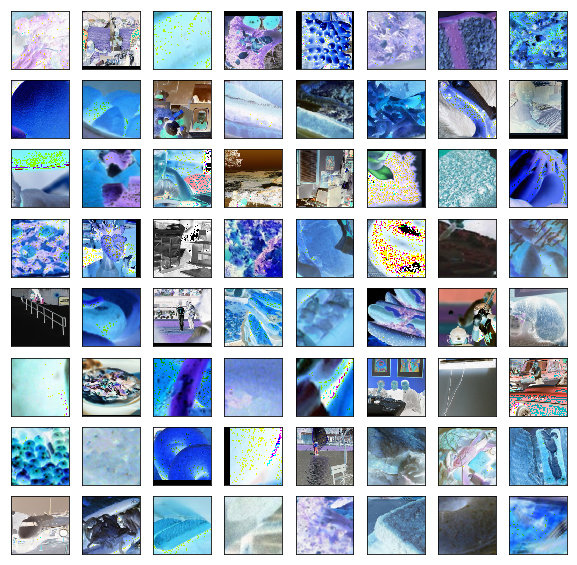

In [3]:
for batch in train_iter:
    img = batch.data[0]
    print(img.shape)
    break

utils.show_images(img.transpose((0,2,3,1)), 8, 8, figsize=(10,10))

## 参数设置

In [4]:
batch_size = 256
learning_rate = .1
weight_decay = .002
num_epochs = 20
ctx_list = [mx.gpu()] # only one
model = 'hybrid'
imagenet_hotdog_idx = 713
positive_class_weight = 5  

## 分类预测

In [15]:
from skimage.color import rgba2rgb

def normalize_color(data):
    return image.color_normalize(data/255, mean=nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                 std=nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))

def classify_hotdog(net, fpath, ctx):
    with open(fpath, 'rb') as f:
        img = image.imdecode(f.read())
    if img.shape[0] == 4:
        img = rgba2rgb(img)
    plt.subplot(1,2,1)
    plt.imshow(img.asnumpy())
    img_crop = image.resize_short(img, 256)
    img_crop, _ = image.center_crop(img_crop, (224,224))
    plt.subplot(1,2,2)
    plt.imshow(img_crop.asnumpy())
    ######## prediction #######
    img_crop = nd.expand_dims(img_crop, axis=0).transpose((0,3,2,1)).astype(np.float32)
    img_crop = normalize_color(img_crop)
    img_crop = img_crop.as_in_context(ctx)
    output = nd.SoftmaxActivation(net(img_crop))
    pred = int(nd.argmax(output, axis=1).asscalar())
    label = ['Not-Hotdog', 'Hotdog']
    return '{}, prob={}'.format(label[pred], output[0][pred].asscalar()) 

## 预训练模型

In [6]:
from mxnet.gluon.model_zoo import vision as models

ResNet18 = models.resnet18_v2(pretrained=True, prefix='deep_dog_')
print(ResNet18.output)

Dense(512 -> 1000, linear)


In [7]:
deep_dog_net = models.resnet18_v2(prefix="deep_dog_", classes=2)
deep_dog_net.collect_params().initialize()
deep_dog_net.features = ResNet18.features

hotdog_w = ResNet18.output.params.get('weight').data()[imagenet_hotdog_idx].reshape((1,-1))
hotdog_b = ResNet18.output.params.get('bias').data()[imagenet_hotdog_idx]

new_hotdog_w = nd.concat(nd.random.normal(0, np.sqrt(1/hotdog_w.shape[1]), shape=hotdog_w.shape),
                        hotdog_w, dim=0)
new_hotdog_b = nd.concat(nd.random.normal(0, 1, shape=hotdog_b.shape),
                        hotdog_b, dim=0)

output_params = deep_dog_net.output.params
output_params.get('weight').set_data(new_hotdog_w)
output_params.get('bias').set_data(new_hotdog_b)

In [8]:
deep_dog_net.output.weight.data()


[[ 0.04654449 -0.0533486  -0.03014199 ...  0.05892551  0.08018401
   0.00751922]
 [ 0.01278208  0.00805827  0.02489643 ... -0.05591827  0.2299718
  -0.11215096]]
<NDArray 2x512 @cpu(0)>

'Not-Hotdog, prob=0.8361030220985413'

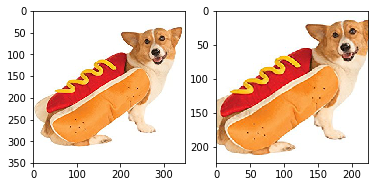

In [9]:
classify_hotdog(deep_dog_net, 'dog_hotdog.jpg', ctx=mx.cpu())

## 评估函数

In [10]:
metricx = metric.create(['acc', 'f1'])

def metric_str(names, accs):
    return ['{}={}'.format(name, acc) for name, acc in zip(names, accs)]

def evaluate_f1score(net, img_iter, ctx_list):
    img_iter.reset()
    for batch in img_iter:
        data = normalize_color(batch.data[0])
        # distributed learning
        data = gluon.utils.split_and_load(data, ctx_list=ctx_list, batch_axis=0)
        labels = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx_list, batch_axis=0)
        # prediction
        preds = []
        for X in data:
            output = net(X)
            preds.append(output)
        metricx.update(labels, preds)
    names, val_acc = metricx.get()
    metricx.reset()
    return names, val_acc

In [11]:
deep_dog_net.collect_params().reset_ctx(ctx_list)
evaluate_f1score(deep_dog_net, val_iter, ctx_list=ctx_list)

(['accuracy', 'f1'], [0.6765625, 0.14008024560124507])

## 多GPU训练函数

In [12]:
def multi_train(train_iter, val_iter, net, learning_rate, ctx_list):
    if isinstance(ctx_list, mx.Context):
        ctx = [ctx]
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':learning_rate, 'wd':weight_decay})
    softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
    
    best_f1score = .0
    val_names, val_accs = evaluate_f1score(net, val_iter, ctx_list)
    logging.info('[Initial] Valid : %s' % (metric_str(val_names, val_accs)))
    for epoch in range(num_epochs):
        start = time()
        train_iter.reset()
        if (epoch+1) % 5 == 0:
            learning_rate *= .1
            trainer.set_learning_rate(learning_rate)
        for batch in train_iter:
            data = normalize_color(batch.data[0])
            data = gluon.utils.split_and_load(data, ctx_list=ctx_list, batch_axis=0)
            labels = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx_list, batch_axis=0)
            
            preds = []
            Ls = [] # softmaxloss list
            # back probagation
            with autograd.record():
                for X, Y in zip(data, labels):
                    output = net(X)
                    loss = softmax_cross_entropy(output, Y) 
                    # * (1+Y*positive_class_weight) / positive_class_weight
                    Ls.append(loss)
                    preds.append(output)
            for L in Ls:
                L.backward()
            trainer.step(batch.data[0].shape[0])
            metricx.update(labels, preds)
        train_names, train_accs = metricx.get() # 训练集的精度和f1 score
        
        # 重置metricx以便检验训练集的精度
        metricx.reset()
        logging.info('[Epoch %d] Train : %s' % (epoch, metric_str(train_names, train_accs)))
        logging.info('[Epoch %d] Time  : %s' % (epoch, time() - start))
        val_names, val_accs = evaluate_f1score(net, val_iter, ctx_list)
        logging.info('[Epoch %d] Valid : %s' % (epoch, metric_str(val_names, val_accs)))
        
        # 如果当前的f1_score大于best_f1，就保存该params
        curr_f1score = val_accs[1]
        if curr_f1score > best_f1score:
            best_f1score = curr_f1score
            logging.info('Best F1 Score Found, CheckPoint... ')
            net.save_params('deep-dog-%d.params' % (epoch))

In [13]:
gpus = 1
contexts = [mx.gpu(i) for i in range(gpus)] if gpus > 0 else [mx.cpu()]
deep_dog_net.hybridize()
deep_dog_net.collect_params().reset_ctx(contexts)
multi_train(train_iter, val_iter, deep_dog_net, learning_rate=learning_rate, ctx_list=contexts)

INFO:root:[Initial] Valid : ['accuracy=0.675', 'f1=0.13922949272949275']
INFO:root:[Epoch 0] Train : ['accuracy=0.9158972537878788', 'f1=0.5538239565520763']
INFO:root:[Epoch 0] Time  : 59.79800033569336
INFO:root:[Epoch 0] Valid : ['accuracy=0.925', 'f1=0.7448784135316643']
INFO:root:Best F1 Score Found, CheckPoint... 
INFO:root:[Epoch 1] Train : ['accuracy=0.9422348484848485', 'f1=0.7010176033550984']
INFO:root:[Epoch 1] Time  : 59.28399991989136
INFO:root:[Epoch 1] Valid : ['accuracy=0.92890625', 'f1=0.7504393207547655']
INFO:root:Best F1 Score Found, CheckPoint... 
INFO:root:[Epoch 2] Train : ['accuracy=0.9507575757575758', 'f1=0.7539857444839237']
INFO:root:[Epoch 2] Time  : 59.151999950408936
INFO:root:[Epoch 2] Valid : ['accuracy=0.9375', 'f1=0.8032153566844112']
INFO:root:Best F1 Score Found, CheckPoint... 
INFO:root:[Epoch 3] Train : ['accuracy=0.9527107007575758', 'f1=0.764901297801525']
INFO:root:[Epoch 3] Time  : 59.389999866485596
INFO:root:[Epoch 3] Valid : ['accuracy=0.9

'Hotdog, prob=0.9526330828666687'

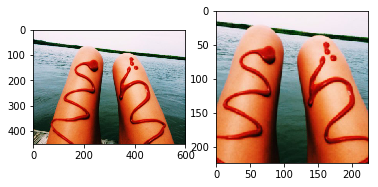

In [19]:
deep_dog_net.load_params('deep-dog-7.params', ctx=mx.gpu())
classify_hotdog(deep_dog_net, 'leg_hotdog.jpg', ctx=mx.gpu())

'Not-Hotdog, prob=0.9870479702949524'

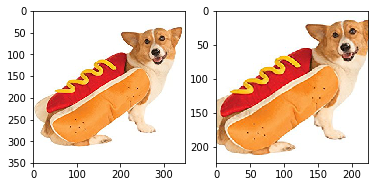

In [20]:
classify_hotdog(deep_dog_net, 'dog_hotdog.jpg', ctx=mx.gpu())

'Not-Hotdog, prob=1.0'

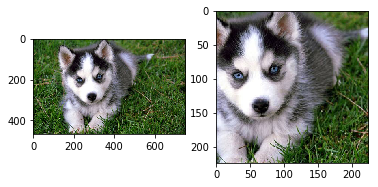

In [21]:
classify_hotdog(deep_dog_net, 'dog.jpg', ctx=mx.gpu())